In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [3]:
#Because this dataframe involves comma separated values, we used the appropriate read function.
apple <- read_csv("data/apple_quality.csv") |>
    head(-1) #This function removes the last row of the dataframe which included NA values and text crediting the author.
apple

Rows: 4001 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Acidity, Quality
dbl (7): A_id, Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,-3.9700485,-2.512336,5.346330,-1.0120087,1.8449004,0.32983980,-0.491590483,good
1,-1.1952172,-2.839257,3.664059,1.5882323,0.8532858,0.86753008,-0.722809367,good
2,-0.2920239,-1.351282,-1.738429,-0.3426159,2.8386355,-0.03803333,2.621636473,bad
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3997,-2.6345153,-2.138247,-2.4404613,0.6572229,2.199709,4.7638592,-1.334611391,bad
3998,-4.0080037,-1.779337,2.3663970,-0.2003294,2.161435,0.2144884,-2.229719806,good
3999,0.2785397,-1.715505,0.1212173,-1.1540748,1.266677,-0.7765715,1.599796456,good


In [4]:
apple_manipulated <- apple |>
    clean_names() |>
    mutate(acidity = as.numeric(acidity))
apple_manipulated

a_id,size,weight,sweetness,crunchiness,juiciness,ripeness,acidity,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-3.9700485,-2.512336,5.346330,-1.0120087,1.8449004,0.32983980,-0.4915905,good
1,-1.1952172,-2.839257,3.664059,1.5882323,0.8532858,0.86753008,-0.7228094,good
2,-0.2920239,-1.351282,-1.738429,-0.3426159,2.8386355,-0.03803333,2.6216365,bad
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3997,-2.6345153,-2.138247,-2.4404613,0.6572229,2.199709,4.7638592,-1.334611,bad
3998,-4.0080037,-1.779337,2.3663970,-0.2003294,2.161435,0.2144884,-2.229720,good
3999,0.2785397,-1.715505,0.1212173,-1.1540748,1.266677,-0.7765715,1.599796,good


In [5]:
set.seed(4321)
#We selected the values we would use for our data analysis, which only included Ripeness, Acidity, and Quality.
#A random sample of 100 was taken because the data set was so large.
apple_select <- apple_manipulated |>
    select(ripeness, acidity, quality)
apple_select

ripeness,acidity,quality
<dbl>,<dbl>,<chr>
0.32983980,-0.4915905,good
0.86753008,-0.7228094,good
-0.03803333,2.6216365,bad
⋮,⋮,⋮
4.7638592,-1.334611,bad
0.2144884,-2.229720,good
-0.7765715,1.599796,good


In [6]:
set.seed(4321)

apple_split <- initial_split(apple_select, prop = 0.75, strata = quality)
apple_train <- training(apple_split)
apple_test <- testing(apple_split)

apple_recipe <- recipe(quality ~ ripeness + acidity, data = apple_train) |>
 step_scale(all_predictors())|>
 step_center(all_predictors())

apple_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
         set_engine("kknn") |>
         set_mode("classification")



In [7]:
apple_vfold<- vfold_cv(apple_train, v=5, strata=quality)

apple_wkflw <- workflow() |>
    add_recipe(apple_recipe) |>
    add_model(apple_spec) 
apple_wkflw

gridvals<-tibble(neighbors=seq(1,20))

apple_results<- apple_wkflw |>
 tune_grid(resamples= apple_vfold, grid=gridvals) |>
 collect_metrics() 

apple_results


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5409962,5,0.005382947,Preprocessor1_Model01
1,roc_auc,binary,0.5409792,5,0.005362711,Preprocessor1_Model01
2,accuracy,binary,0.5409962,5,0.005382947,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,roc_auc,binary,0.6471332,5,0.01349593,Preprocessor1_Model19
20,accuracy,binary,0.5999963,5,0.01321200,Preprocessor1_Model20
20,roc_auc,binary,0.6494338,5,0.01239439,Preprocessor1_Model20


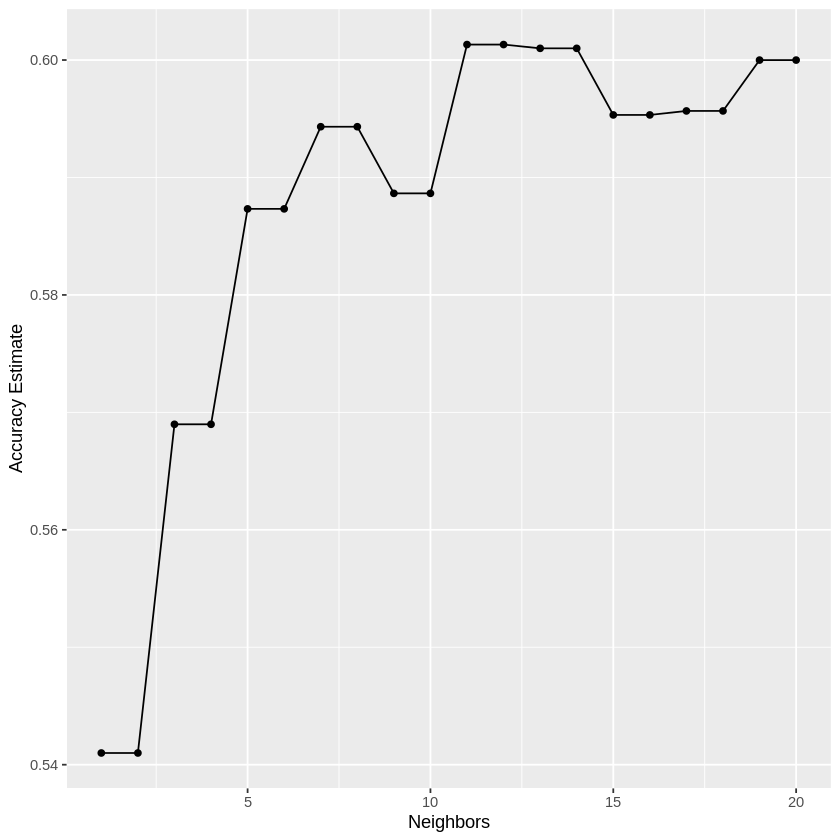

In [10]:
accuracies<-apple_results |>
 filter(.metric=="accuracy")

accuracies_k<- ggplot(accuracies,aes(x= neighbors, y=mean))+
 geom_point() +
 geom_line() +
 labs(x="Neighbors", y= "Accuracy Estimate")
accuracies_k

In [ ]:
# apple_split <- initial_split(apple_select, prop = 0.75, strata = Quality)
# apple_train <- training(apple_split)
# apple_test <- testing(apple_split)

# apple_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 



In [ ]:


# # apple_split <- initial_split(apple_select, prop = 0.75, strata = Quality)
# # apple_train <- training(apple_split)
# # apple_test <- testing(apple_split)

# # apple_recipe <- recipe(Quality ~ Ripeness + Acidity, data = apple_train) #Data is already scaled and centered, so there is no need to use step_scale.

# # knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
# #         set_engine("kknn") |>
# #         set_mode("classification")

# # knn_fit <- workflow() |>
# #     add_recipe(apple_recipe) |>
# #     add_model(knn_spec) |>
# #     fit(data = apple_train)

# # validation_predicted <- predict(knn_fit, apple_test) |>
# #     bind_cols(apple_test)

# # set.seed(1)

# # apple_vfold<- vfold_cv(apple_train, v=5, strata=Quality)

# # apple_recipe<- recipe(Quality~.,data=apple_train)|>
# #  step_scale(all_predictors())|>
# #  step_center(all_predictors())

# # knn_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
# # set_engine("kknn")|>
# # set_mode("classification")

# # knn_results<-workflow() |>
# #  add_recipe(apple_recipe) |>
# #  add_model(knn_spec) |>
# #  tune_grid(resamples=apple_vfold, grid=10) |>
# #  collect_metrics()
# # knn_results


# set.seed(1)
# apple_split<-initial_split(selected_data, prop=0.75, strata=Quality)
# apple_train<-training(apple_split)
# apple_test<-testing(apple_split)
# glimpse(apple_train)
# #create the split


In [ ]:

#In the following code, a K-nn classifier is created using the training data and cross validation with 10 folds is completed to select an optimal K value.

#quality_good_data <- data |>
#    select(Ripeness, Acidity, Quality) |>
#    filter(Quality == "good", na.rm = TRUE)

#quality_good_data

#options(repr.plot.width = 5, repr.plot.height = 5)
#plot_filtered_good_data <- quality_good_data  |>
#    ggplot(aes(x= Ripeness, y = Acidity, color = Quality)) +
#    geom_point(alpha =0.4) +
#    labs(x = "Ripeness",
#         y = "Acidity",
#         color = "Quality")
#plot_filtered_good_data

# options(repr.plot.width = 5, repr.plot.height = 5)

# quality_bad_data <- data |>
#     select(Ripeness, Acidity, Quality) |>
#     filter(Quality == "bad", na.rm = TRUE)

# quality_bad_data
# plot_filtered_bad_data <- quality_bad_data  |>
#     ggplot(aes(x= Ripeness, y = Acidity, color = Quality)) +
#     geom_point(alpha =0.4) +
#     labs(x = "Ripeness",
#          y = "Acidity",
#          color = "Quality")
# plot_filtered_bad_data